## Load Data

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import random

import warnings

In [5]:
# To ignore warnings caused by tensorflow
warnings.filterwarnings('ignore')

mnist = input_data.read_data_sets("MNIST_data/", reshape=False)
X_train, y_train = mnist.train.images, mnist.train.labels
X_valid, y_valid = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print("Train Set: {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_valid)))
print("Test Set: {} samples".format(len(X_test)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

Image Shape: (28, 28, 1)
Train Set: 55000 samples
Validation Set: 5000 samples
Test Set: 10000 samples


### Reshape image to fit the LeNet arch
The MNIST data that TensorFlow pre-loads comes as 28x28x1 images.However, the LeNet architecture only accepts 32x32xC images.

In order to reformat the MNIST data into a shape that LeNet will accept, we pad the data(28+2+2=32).

In [6]:
X_train = np.pad(X_train, ((0,0), (2,2), (2,2), (0,0)), 'constant')
X_valid = np.pad(X_valid, ((0,0), (2,2), (2,2), (0,0)), 'constant')
X_test = np.pad(X_test, ((0,0), (2,2), (2,2), (0,0)), 'constant')

print("Updated Image Shape: {}".format(X_train[0].shape))

Updated Image Shape: (32, 32, 1)


## Visualize Data

0


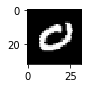

In [11]:
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap='gray')
print(y_train[index])

## Preprocess Data

In [12]:
X_train, y_train = shuffle(X_train, y_train)

## Setup Tensorflow
##### Epochs:
How many times to run my training data through the network. In general the more epochs ,the better my model will train but also the longer training will take.
##### Batch Size:
How many training images to run through the network at a time. The larger the batch size the faster my model will train, but my processor may have a memory limit on how large a batch it can run.

In [13]:
EPOCHS = 10
BATCH_SIZE = 128

## Implement LeNet-5

In [14]:
def LeNet(x):
    mu = 0
    sigma = 0.1
    
    conv1_w = tf.Variable(tf.truncated_normal(shape=(5,5,1,6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_w, strides=[1,1,1,1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    conv2_w = tf.Variable(tf.truncated_normal(shape=(5,5,6,16), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_w, strides=[1,1,1,1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    fc0 = flatten(conv2)
    
    fc1_w = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.add(tf.matmul(fc0, fc1_w), fc1_b)
    fc1 = tf.nn.relu(fc1)
    
    fc2_w = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.add(tf.matmul(fc1, fc2_w), fc2_b)
    fc2 = tf.nn.relu(fc2)
    
    fc3_w = tf.Variable(tf.truncated_normal(shape=(84, 10), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(10))
    fc3 = tf.add(tf.matmul(fc2, fc3_w), fc3_b)
    return fc3

## Features and Labels
I initialize the batch size to None which allows the placeholder to later accept a batch of any size, and I set the image dimensions to 32x32x1. In this case, my labels come through withh sparse variables which just means that they're integers. They aren't one-hot encoded yet.

In [15]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)

## Training Pipeline

In [17]:
# To ignore warnings caused by tensorflow
warnings.filterwarnings('ignore')

lr = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
training = optimizer.minimize(loss)

## Model Evaluation
The evaluation pipeline I create here will evaluate how good the model is.

In [18]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(x_data, y_data):
    num_examples = len(x_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = x_data[offset: offset+BATCH_SIZE]
        batch_y = y_data[offset:offset+BATCH_SIZE]
        batch_accuracy = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += batch_accuracy * len(batch_x)
    return total_accuracy / num_examples        

## Train the Model

In [20]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x = X_train[offset:end]
            batch_y = y_train[offset:end]
            sess.run(training, feed_dict={x: batch_x, y:batch_y})
            
        validation_acc = evaluate(X_valid, y_valid)
        print("EPOCH {}...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_acc))
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'lenet')
    print("Model saved ")

Training...

EPOCH 1...
Validation Accuracy = 0.967

EPOCH 2...
Validation Accuracy = 0.982

EPOCH 3...
Validation Accuracy = 0.983

EPOCH 4...
Validation Accuracy = 0.985

EPOCH 5...
Validation Accuracy = 0.987

EPOCH 6...
Validation Accuracy = 0.984

EPOCH 7...
Validation Accuracy = 0.986

EPOCH 8...
Validation Accuracy = 0.987

EPOCH 9...
Validation Accuracy = 0.988

EPOCH 10...
Validation Accuracy = 0.988

Model saved 


## Visualizing Layers
 - image_input: the test image being fed into the network to produce the feature maps
 - tf_activation: should be a tf variable name used during my training procedure that represents the calculated state of a specific weight layer
   **Note**: to get access to tf_activation, the session should be interactive which can be achieved with the following commands.
       sess = tf.InteractiveSession()
       sess.as_default()
 - activation_min/max: can be used to view the activation constant in more detail, by default matplot sets min and max to the actual min and max values of the output.
 - plt_num: used to plot out multiple different weight feature map sets on the block, just extend the plot number for each new feature map entry

In [23]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=1, plt_num=1):
    activation = tf_activation.eval(session=sess, feed_dict={x: image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    
    for featuremap in range(featuremaps):
        plt.subplot(6,8,featuremap+1)
        plt.title('FeatureMap ' + str(featuremap))
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:,featuremap], interpolation="nearest", vmin=activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:,featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min != -1:
            plt.imshow(activation[0,:,:,featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")